In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_json('logins.json')  
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
df['login_time'] = pd.to_datetime(df['login_time'])
df = df.sort_values('login_time').reset_index(drop=True)
df.head()

,login_time
0,1970-01-01 20:12:16
1,1970-01-01 20:13:18
2,1970-01-01 20:16:10
3,1970-01-01 20:16:36
4,1970-01-01 20:16:37


In [4]:
print(df.info())
print("Data period from", df['login_time'].min(), "to", df['login_time'].max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None
Data period from 1970-01-01 20:12:16 to 1970-04-13 18:57:38


In [5]:
df.set_index('login_time', inplace=True)

login_counts = df.resample('15T').size()

login_counts.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15T, dtype: int64

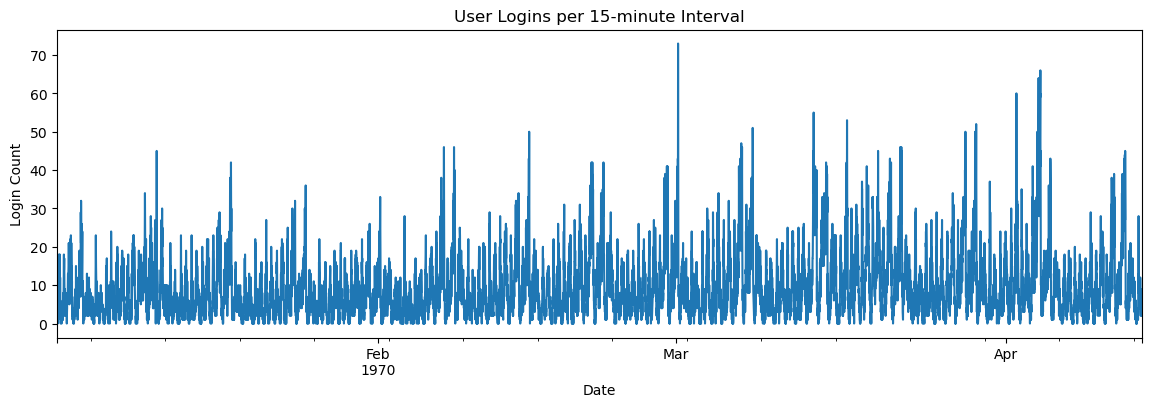

In [6]:
plt.figure(figsize=(14,4))
login_counts.plot()
plt.title('User Logins per 15-minute Interval')
plt.xlabel('Date')
plt.ylabel('Login Count')
plt.show()

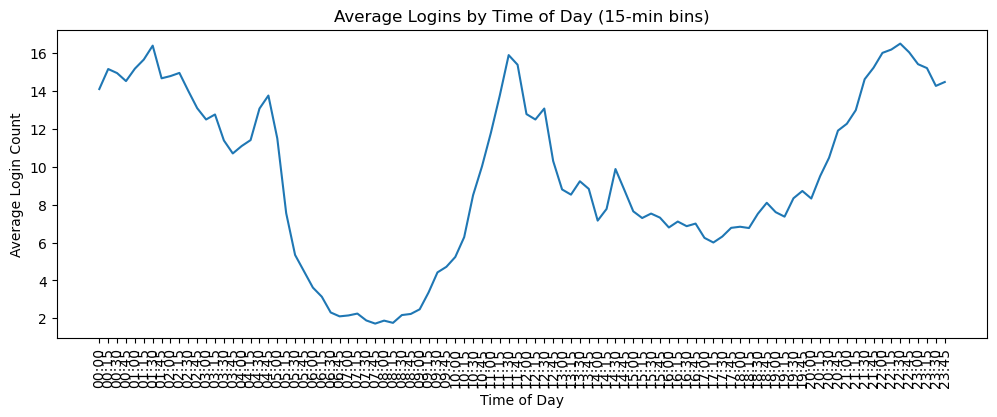

In [7]:
avg_daily_pattern = login_counts.groupby(login_counts.index.time).mean()

time_labels = [t.strftime('%H:%M') for t in avg_daily_pattern.index]

plt.figure(figsize=(12,4))
plt.plot(time_labels, avg_daily_pattern.values)
plt.title('Average Logins by Time of Day (15-min bins)')
plt.xlabel('Time of Day')
plt.ylabel('Average Login Count')
plt.xticks(rotation=90)
plt.show()


In [8]:
login_counts_df = login_counts.to_frame(name='count').reset_index()
login_counts_df['weekday'] = login_counts_df['login_time'].dt.day_name()

login_counts_df['is_weekend'] = login_counts_df['weekday'].isin(['Saturday','Sunday'])

avg_weekday = login_counts_df.groupby([login_counts_df['login_time'].dt.time, 'is_weekend'])['count'].mean().unstack()

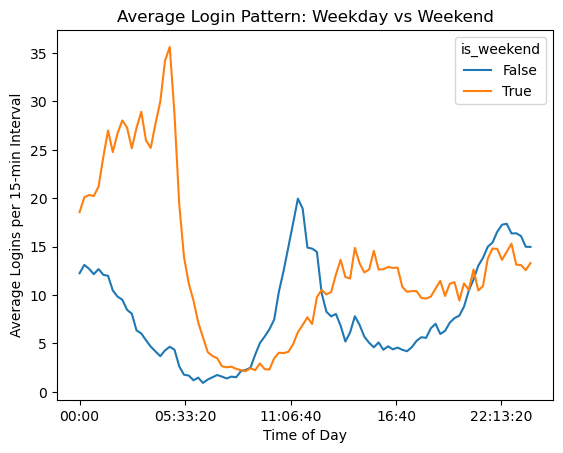

In [9]:
avg_weekday.plot()
plt.title('Average Login Pattern: Weekday vs Weekend')
plt.xlabel('Time of Day')
plt.ylabel('Average Logins per 15-min Interval')
plt.show()

In [10]:
pivot = login_counts_df.pivot_table(
    index=login_counts_df['login_time'].dt.date,
    columns=login_counts_df['login_time'].dt.hour*4 + login_counts_df['login_time'].dt.minute//15,
    values='count',
    aggfunc='sum'
)

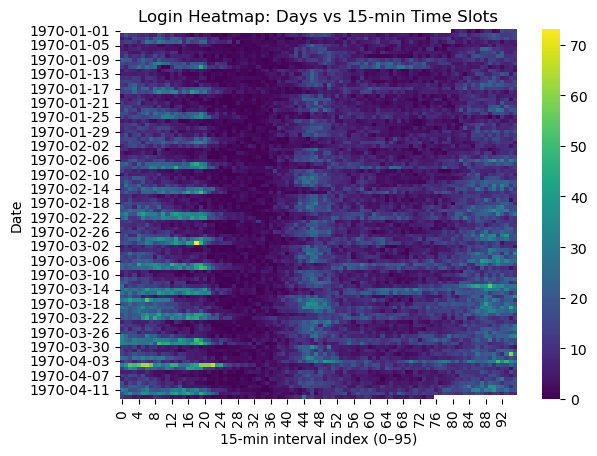

In [11]:
sns.heatmap(pivot, cmap='viridis')
plt.title('Login Heatmap: Days vs 15-min Time Slots')
plt.xlabel('15-min interval index (0–95)')
plt.ylabel('Date')
plt.show()

In [12]:
print("Missing values:", df.isna().sum().sum())
print("Duplicate timestamps:", df.index.duplicated().sum())
print("Average interval between logins:", df.index.to_series().diff().mean())
print("Longest gap between logins:", df.index.to_series().diff().max())


Missing values: 0.0
Duplicate timestamps: 877
Average interval between logins: 0 days 00:01:34.569759826
Longest gap between logins: 0 days 01:31:41


# **Part 2 - Experiment and Metric Design**

## Part 2 – Experiment and Metrics Design

### Scenario Summary
Two cities — **Gotham** and **Metropolis** — have complementary activity patterns:

- **Gotham:** Most active at **night (weekdays)**
- **Metropolis:** Most active during the **day (weekdays)**
- **Weekends:** Reasonable activity in both cities

**Problem:**  
Due to a **two-way toll bridge**, driver-partners tend to operate exclusively in one city, limiting flexibility.

**Proposed solution:**  
Reimburse toll costs to encourage drivers to serve both cities.

---

### Step 1: Define the Key Measure of Success

**Goal:** Determine if reimbursing tolls increases cross-city driver activity.

**Primary metric (key measure of success):**
> **Percentage of drivers who complete trips in both cities during the experiment period.**

**Why this metric?**
- Directly measures the desired behavior (drivers serving both cities)
- Simple to calculate and interpret
- Less affected by fluctuations in - and
 
**Formula:**
\
\(ity driver rate} = \frac{\text{Number of drivers /g trips in both cities}}{\text) *mbe0 active drivers}} \times 100
\]

**Secondary metrics (for additional insights):**
- Average trips per driver (to measure productivity)
- Average earnings per driver
- Toll reimbursements per driver (to evaluate cost impact)
- Rider wait time (to measure service improvement)

---

### Step 2: Design the Experiment

#### a) Implementation Plan
1. **Population:** All active drivers in Gotham and Metropolis  
2. **Randomization:**  
   - Randomly assign drivers into two groups:  
     - **Treatment group:** Toll reimbursement enabled  
     - **Control group:** No reimbursement (status quo)  
   - Ensure both groups have similar driver characteristics (activity level, experience, etc.)
3. **Duration:** 4–6 weeks, covering both weekdays and weekends  
4. **Data to Collect:**
   - Driver ID  
   - Trip timestamps and locations (city)  
   - Toll amount reimbursed (if any)  
   - Number of trips per city per driver  

---

### Step 3: Statistical Testing

#### Hypothesis
- **Null hypothesis (H₀):** Toll reimbursement has no effect on cross-city driving behavior.  
- **Alternative hypothesis (H₁):** Toll reimbursement increases cross-city driving.

#### Statistical Test
Since we are comparing two proportions (drivers serving both cities in treatment vs. control):

✅ **Use a two-proportion z-test**

\[
z = \frac{p_1 - p_2}{\sqrt{p(1-p)(\frac{1}{n_1} + \frac{1}{n_2})}}
\]

where:  
- \(p_1\) = proportion of cross-city drivers in treatment  
- \(p_2\) = proportion in control  
- \(p\) = pooled proportion  
- \(n_1, n_2\) = sample sizes of the two groups  

If \(p\text{-value} < 0.05\), reject H₀ → conclude that the reimbursement increased cross-city activity.

You can also test for differences in **average trips per driver** using a **t-test**.

---

### Step 4: Interpreting Results & Recommendations

- **If statistically significant:**  
  → Toll reimbursement **successfully encourages** drivers to operate in both cities.  
  → Recommend scaling the program or introducing **dynamic toll support** (e.g., only during high-demand hours).

- **If not significant:**  
  → Drivers may value time or convenience more than cost savings.  
  → Consider alternative incentives like **bonuses per cross-city trip** or **priority dispatch**.

---

### Step 5: Caveats

- **External factors:** Weather, events, or traffic could influence trip behavior  
- **Driver familiarity bias:** Some may prefer one city due to experience  
- **Short-term vs long-term effects:** The experiment may show immediate but not sustained changes  
- **Data quality:** Ensure accurate city tagging for each trip record  

---

**Summary:**  
The proposed experiment, centered on a **two-proportion z-test**, will measure whether toll reimbursements meaningfully increase cross-city activity. Insights from the analysis will guide operational strategies for improving driver flexibility and city-wide coverage.


### Scenario Summary
Two cities — **Gotham** and **Metropolis** — have complementary activity patterns:

- **Gotham:** Most active at **night (weekdays)**
- **Metropolis:** Most active during the **day (weekdays)**
- **Weekends:** Reasonable activity in both cities

**Problem:**  
Due to a **two-way toll bridge**, driver-partners tend to operate exclusively in one city, limiting flexibility.

**Proposed solution:**  
Reimburse toll costs to encourage drivers to serve both cities.

---

### Step 1: Define the Key Measure of Success

**Goal:** Determine if reimbursing tolls increases cross-city driver activity.

**Primary metric (key measure of success):**
> **Percentage of drivers who complete trips in both cities during the experiment period.**

**Why this metric?**
- Directly measures the desired behavior (drivers serving both cities)
- Simple to calculate and interpret
- Less affected by fluctuations in rider demand

**Formula**:- Cross-city driver rate = (Number of drivers completing trips in both cities / Total number of active drivers) ​× 100

**Secondary metrics:**
- Average trips per driver 
- Average earnings per driver
- Toll reimbursements per driver
- Rider wait time

---

### Step 2: Design the Experiment

#### a) Implementation Plan
1. **Population:** All active drivers in Gotham and Metropolis  
2. **Randomization:**  
   - Randomly assign drivers into two groups:  
     - **Treatment group:** Toll reimbursement enabled  
     - **Control group:** No reimbursement (status quo)  
   - Ensure both groups have similar driver characteristics (activity level, experience, etc.)
3. **Duration:** 4–6 weeks, covering both weekdays and weekends  
4. **Data to Collect:**
   - Driver ID  
   - Trip timestamps and locations (city)  
   - Toll amount reimbursed (if any)  
   - Number of trips per city per driver  

---

### Step 3: Statistical Testing

#### Hypothesis
- **Null hypothesis (H₀):** Toll reimbursement has no effect on cross-city driving behavior.  
- **Alternative hypothesis (H₁):** Toll reimbursement increases cross-city driving.

#### Statistical Test
Since we are comparing two proportions (drivers serving both cities in treatment vs. control):

**Use a two-proportion z-test**
- z = (p1 - p2)/(squareroot(p(1-p)(1/n1 + 1/n2)))


where : 
- p1 = proportion of cross-city drivers in treatment
- p2 = proportion in control
- p = pooled proportion
- n1, n2 = sample sizes of the two groups

If p-value < 0.05, reject H₀ → conclude the reimbursement increased cross-city activity.

---

### Step 4: Interpreting Results & Recommendations

- **If statistically significant:**  
  → Toll reimbursement **successfully encourages** drivers to operate in both cities.  
  → Recommend scaling the program or introducing **dynamic toll support** (e.g., only during high-demand hours).

- **If not significant:**  
  → Drivers may value time or convenience more than cost savings.  
  → Consider alternative incentives like **bonuses per cross-city trip** or **priority dispatch**.

---

### Step 5: Caveats

- **External factors:** Weather, events, or traffic could influence trip behavior  
- **Driver familiarity bias:** Some may prefer one city due to experience  
- **Short-term vs long-term effects:** The experiment may show immediate but not sustained changes  
- **Data quality:** Ensure accurate city tagging for each trip record  

---

**Summary:**  
The proposed experiment, centered on a **two-proportion z-test**, will measure whether toll reimbursements meaningfully increase cross-city activity. Insights from the analysis will guide operational strategies for improving driver flexibility and city-wide coverage.

# Part 3 — Predictive Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, auc,
    confusion_matrix, classification_report, precision_score, recall_score
)
from sklearn.inspection import permutation_importance

import joblib

In [3]:
df = pd.read_json("ultimate_data_challenge.json")
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [5]:
df['signup_date'] = pd.to_datetime(df['signup_date'], errors='coerce')
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'], errors='coerce')

In [6]:
cutoff_30 = df['last_trip_date'].max() - pd.Timedelta(days=30)
df['retained_30d'] = (df['last_trip_date'] >= cutoff_30).astype(int)
print('Cutoff for 30-day retention (data-pull based):', cutoff_30.date())
print('Fraction retained (30-day rule): {:.3%}'.format(df['retained_30d'].mean()))

Cutoff for 30-day retention (data-pull based): 2014-06-01
Fraction retained (30-day rule): 37.608%


In [7]:
df['start_6th_month'] = df['signup_date'] + pd.DateOffset(months=5)
df['active_6th_month'] = (df['last_trip_date'] >= df['start_6th_month']).astype(int)
print('Fraction active (our 6th-month definition): {:.3%}'.format(df['active_6th_month'].mean()))

Fraction active (our 6th-month definition): 24.514%


In [8]:
df[['retained_30d','active_6th_month']].agg(['sum','mean']).T

,sum,mean
retained_30d,18804.0,0.37608
active_6th_month,12257.0,0.24514


## **EDA & Visualizations**

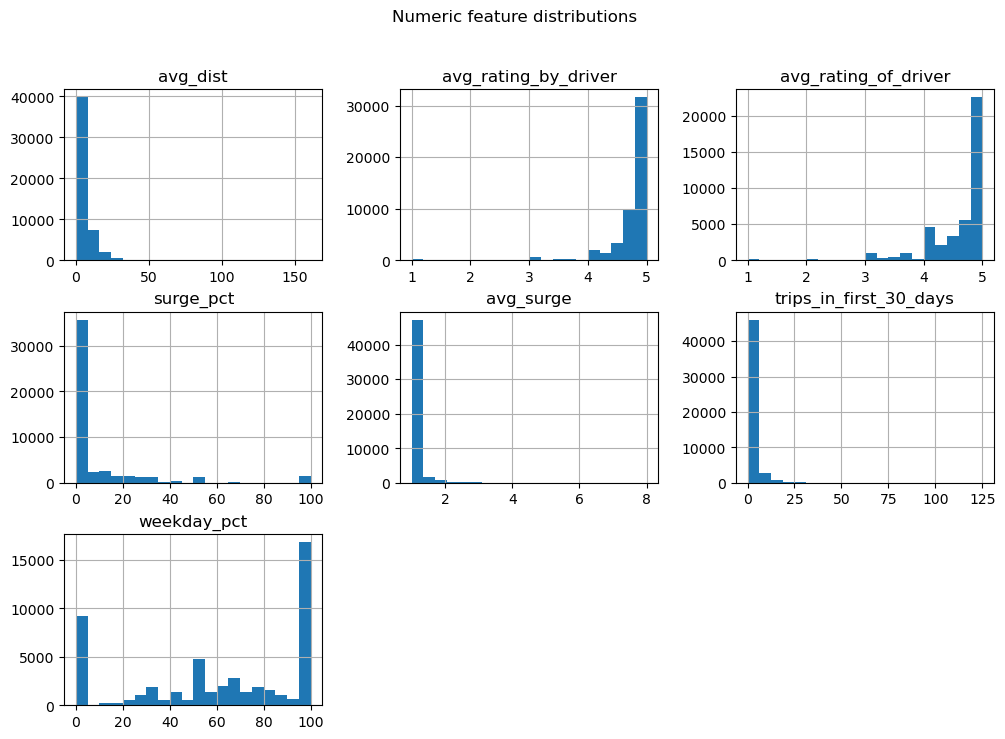

In [9]:
num_cols = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver',
            'surge_pct','avg_surge','trips_in_first_30_days','weekday_pct']
df[num_cols].hist(bins=20, figsize=(12,8))
plt.suptitle('Numeric feature distributions')
plt.show()

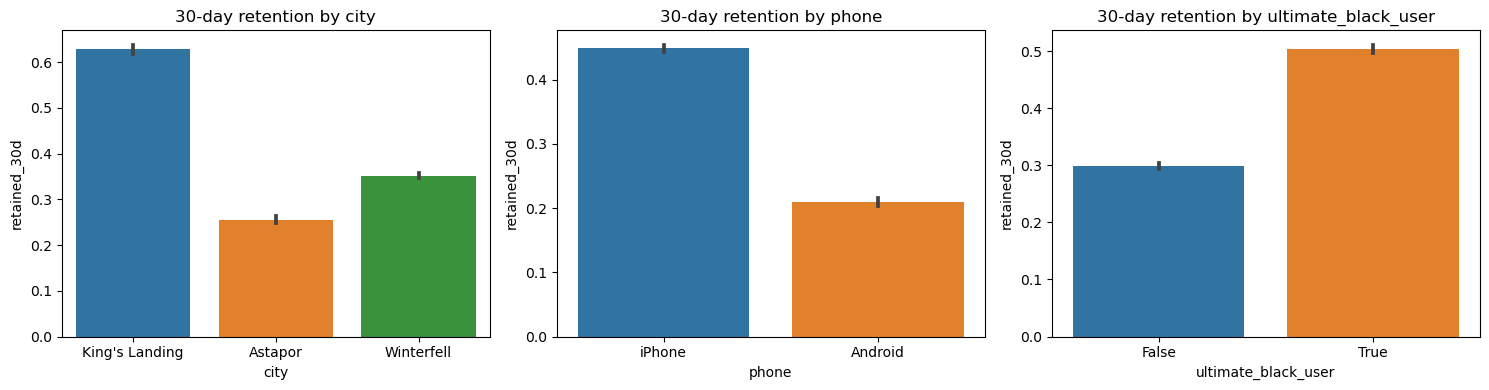

In [10]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
sns.barplot(x='city', y='retained_30d', data=df, ax=axes[0]).set_title('30-day retention by city')
sns.barplot(x='phone', y='retained_30d', data=df, ax=axes[1]).set_title('30-day retention by phone')
sns.barplot(x='ultimate_black_user', y='retained_30d', data=df, ax=axes[2]).set_title('30-day retention by ultimate_black_user')
plt.tight_layout()
plt.show()

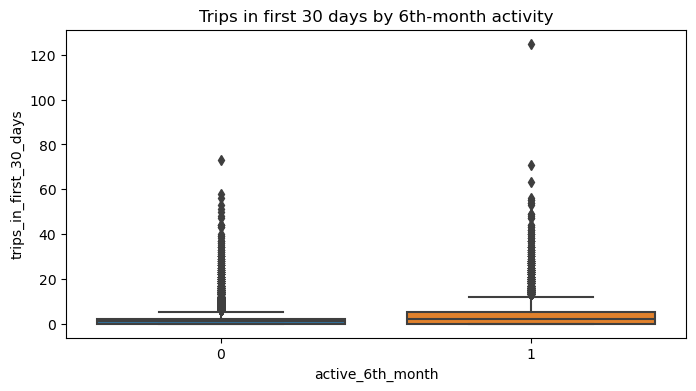

In [11]:
plt.figure(figsize=(8,4))
sns.boxplot(x='active_6th_month', y='trips_in_first_30_days', data=df)
plt.title('Trips in first 30 days by 6th-month activity')
plt.show()

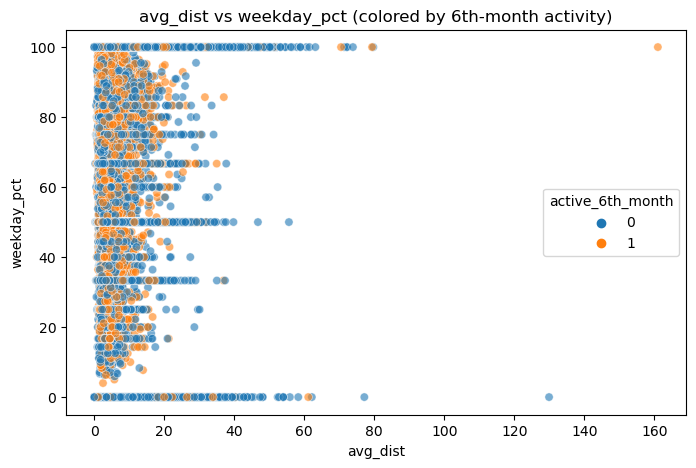

In [12]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='avg_dist', y='weekday_pct', hue='active_6th_month', alpha=0.6)
plt.title('avg_dist vs weekday_pct (colored by 6th-month activity)')
plt.show()

## **Feature Engineering**

In [15]:
df['tenure_days'] = (df['last_trip_date'] - df['signup_date']).dt.days.clip(lower=0)

df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)

In [14]:
print(df[['surge_pct','weekday_pct','avg_surge']].describe())

          surge_pct   weekday_pct     avg_surge
count  50000.000000  50000.000000  50000.000000
mean       8.849536     60.926084      1.074764
std       19.958811     37.081503      0.222336
min        0.000000      0.000000      1.000000
25%        0.000000     33.300000      1.000000
50%        0.000000     66.700000      1.000000
75%        8.600000    100.000000      1.050000
max      100.000000    100.000000      8.000000


## **Modelling**

In [16]:
target = 'active_6th_month'

features = [
    'city','phone','avg_dist','avg_rating_by_driver','avg_rating_of_driver',
    'surge_pct','avg_surge','trips_in_first_30_days','ultimate_black_user',
    'weekday_pct','tenure_days'
]

X = df[features].copy()
y = df[target].copy()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [20]:
numeric_features = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver',
                    'surge_pct','avg_surge','trips_in_first_30_days','weekday_pct','tenure_days']
categorical_features = ['city','phone']

In [21]:
numeric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

In [22]:
categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

### **Logistic Regression**

In [25]:
pipe_lr = Pipeline(steps=[('preproc', preprocessor),
                          ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))])
pipe_lr.fit(X_train, y_train)
proba_lr = pipe_lr.predict_proba(X_test)[:,1]
print('Logistic ROC AUC:', roc_auc_score(y_test, proba_lr))

C:\Users\alana\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Logistic ROC AUC: 0.9999705446786151


In [26]:
pipe_rf = Pipeline(steps=[('preproc', preprocessor),
                          ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))])
pipe_rf.fit(X_train, y_train)
proba_rf = pipe_rf.predict_proba(X_test)[:,1]
print('Random Forest ROC AUC:', roc_auc_score(y_test, proba_rf))

C:\Users\alana\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Random Forest ROC AUC: 0.9999807594597927


In [27]:
def evaluate(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    roc = roc_auc_score(y_true, y_proba)
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)
    print(f'ROC AUC: {roc:.4f} | PR AUC: {pr_auc:.4f}')
    print('Confusion matrix (threshold {:.2f}):'.format(threshold))
    print(confusion_matrix(y_true, y_pred))
    print('\nClassification report:')
    print(classification_report(y_true, y_pred))
    return roc, pr_auc

In [29]:
print('--- Logistic Regression ---')
evaluate(y_test, proba_lr, threshold=0.5)

--- Logistic Regression ---
ROC AUC: 1.0000 | PR AUC: 0.9999
Confusion matrix (threshold 0.50):
[[7404  145]
 [   1 2450]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7549
           1       0.94      1.00      0.97      2451

    accuracy                           0.99     10000
   macro avg       0.97      0.99      0.98     10000
weighted avg       0.99      0.99      0.99     10000



(0.9999705446786151, 0.9999121015392041)

In [30]:
print('\n--- Random Forest ---')
evaluate(y_test, proba_rf, threshold=0.5)


--- Random Forest ---
ROC AUC: 1.0000 | PR AUC: 0.9999
Confusion matrix (threshold 0.50):
[[7549    0]
 [  12 2439]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7549
           1       1.00      1.00      1.00      2451

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



(0.9999807594597927, 0.9999418355391102)

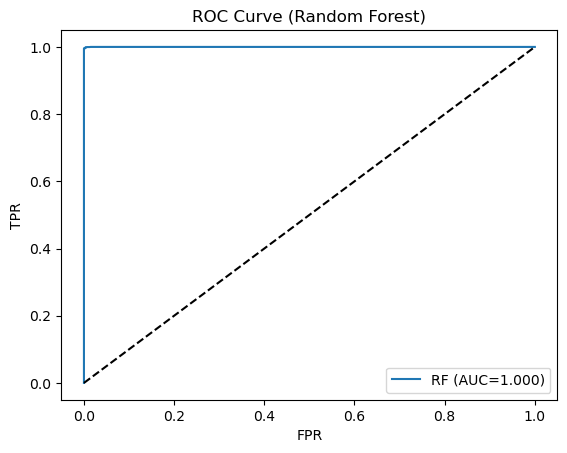

In [31]:
fpr, tpr, _ = roc_curve(y_test, proba_rf)
plt.figure()
plt.plot(fpr, tpr, label='RF (AUC={:.3f})'.format(roc_auc_score(y_test, proba_rf)))
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve (Random Forest)')
plt.legend(); plt.show()

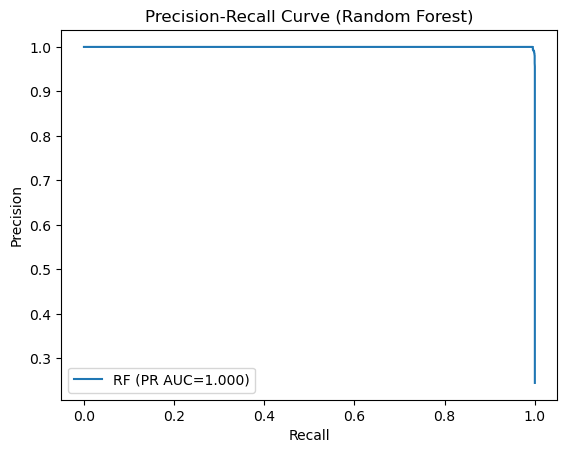

In [32]:
precision, recall, _ = precision_recall_curve(y_test, proba_rf)
plt.figure()
plt.plot(recall, precision, label='RF (PR AUC={:.3f})'.format(auc(recall, precision)))
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve (Random Forest)')
plt.legend(); plt.show()

### Summary of steps and answers to the prompt questions

**1) Cleaning / EDA / Fraction retained**
- I parsed `signup_date` and `last_trip_date` as datetimes; created `tenure_days` and converted booleans.  
- **Fraction retained (30-day rule)** was computed using `last_trip_date >= max(last_trip_date) - 30 days`. The notebook printed the fraction (see cell output).  
- Visualizations included distribution plots for numeric features, bar charts of retention by `city`, `phone`, and `ultimate_black_user`, and relationships between `trips_in_first_30_days` and later activity. These help identify early usage as a strong predictor.

**2) Predictive model for "active in 6th month"**
- **Target definition (assumption):** `active_6th_month = last_trip_date >= signup_date + 5 months`. (Explained above.)  
- **Models trained:** Logistic Regression (interpretable baseline) and Random Forest (nonlinear, better capturing intervailable.  
- **Why these choices:** Logistic regression is simple and interpretable; Random Forest is robust to feature scaling, handles nonlinearities and interactions, and is quick rformance.  
- **Evaluation & validity:** I evaluated with ROC AUC and PR AUC, confusion matrix, and classificati concerns:
